#Set Up Environment

In [1]:
## Comet ML
!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "LtCuxFoEwG44gHY0WBLxIYbdt"
assert COMET_API_KEY != "", "Please insert your Comet API Key"
# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl
import os
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
# Check that we are using a GPU, if not switch runtimes
# using Runtime > Change Runtime Type > GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
    raise ValueError("GPU is not available. Change Colab runtime.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 43.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.8/467.8 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00


#Datasets

In [2]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")
# Create a simple check to avoid re-downloading3/15
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)
# Instantiate a TrainingDatasetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

100%|██████████| 1.18G/1.18G [00:15<00:00, 79.6MB/s]

Opening /root/.cache/mitdeeplearning/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [4]:

number_of_training_examples = loader.get_train_size()
if number_of_training_examples > 0:
  (images, labels) = loader.get_batch(100)
  B, C, H, W = images.shape
  print(f"Number of training examples: {number_of_training_examples}")
  print(f"Batch shape: {images.shape}")
else:
  print("No training examples found.")


Number of training examples: 109914
Batch shape: (100, 3, 64, 64)


Change the sliders to look at positive and negative training examples

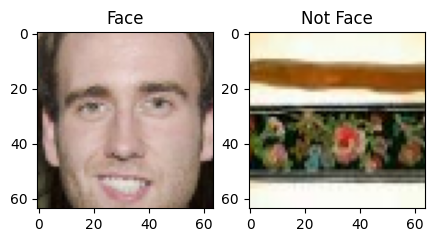

In [8]:
### Examining the CelebA training dataset ###
# @title Change the sliders to look at positive and negative
face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)
idx_face = 49 # @param {type:"slider", min:0, max:50, step:1
idx_not_face = 23 # @param {type:"slider", min:0, max:50, step:1
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

#CNN for facial detection

Define and train the CNN model

In [9]:
## Define the CNN model ###
n_filters = 12 # base number of convolutional filters4/15
in_channels = images.shape[1]
def make_standard_classifier(n_outputs):
    """Create a standard CNN classifier."""
    # Start by first defining a convolutional block
    class ConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
            super().__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)
        def forward(self, x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)
            return x
    # now use the block to define the classifier
    model = nn.Sequential(
        ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
        ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
        nn.Flatten(),
        nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, n_outputs),
    )
    return model.to(device)
# call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

Now let's train the standard CNN!

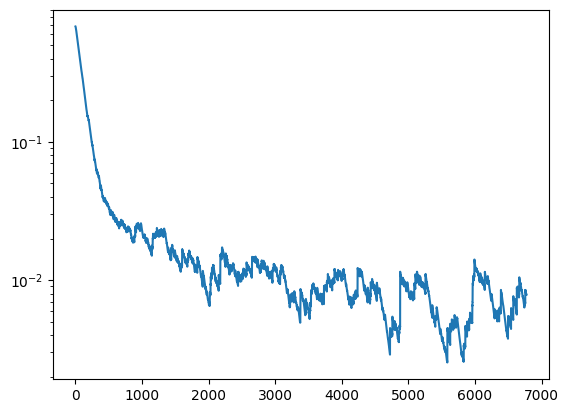

100%|██████████| 3434/3434 [00:35<00:00, 96.95it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : double_degree_606
COMET INFO:     url                   : https://www.comet.com/sathikaranathunga/6s191-lab2-part2-cnn/10abc0e4573f41cc834cab2d4bec39bc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (3.57930986183419e-07, 0.6951777935028076)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1z4_6b0i5O8u0u1ANmuLGaRebDzbSA6G0
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET

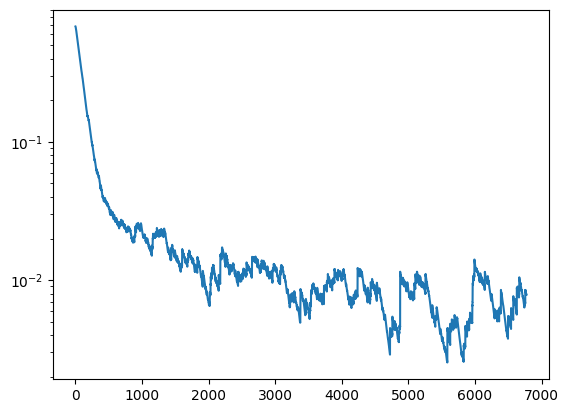

In [11]:

### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
  # end any prior experiments
  if "experiment" in locals():
    experiment.end()
  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()
  return experiment

### Train the standard CNN ###
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)
experiment = create_experiment("6S191_Lab2_Part2_CNN", params)
optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params["learning_rate"]
)  # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists
# set the model to train mode
standard_classifier.train()


def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)
    # clear the gradients
    optimizer.zero_grad()
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss


# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())
        experiment.log_metric("loss", loss_value, step=step)
        step += 1
experiment.end()

We will also evaluate our networks on an independent test dataset containing faces that were not seen during training. For the test data, we'll
look at the classification accuracy across four different demographics, based on the Fitzpatrick skin scale and sex-based labels: dark-skinned
male, dark-skinned female, light-skinned male, and light-skinned female.
Let's take a look at some sample faces in the test set.

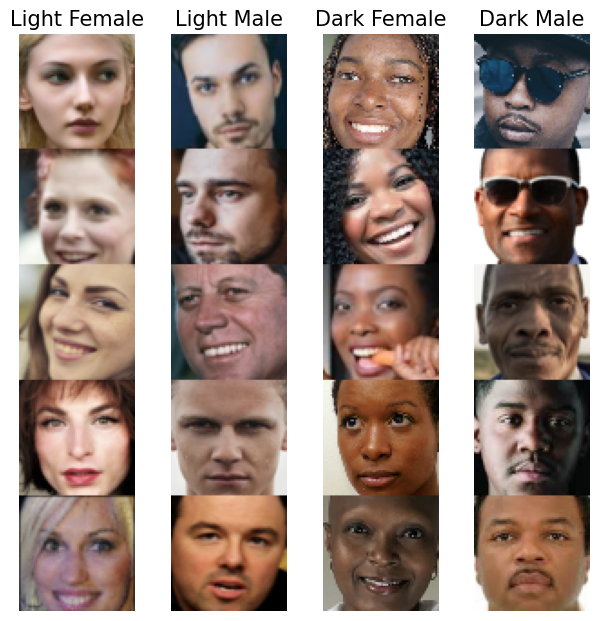

In [12]:
### Load test dataset and plot examples ###
test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just
trained

Text(0.5, 1.0, 'Standard classifier predictions')

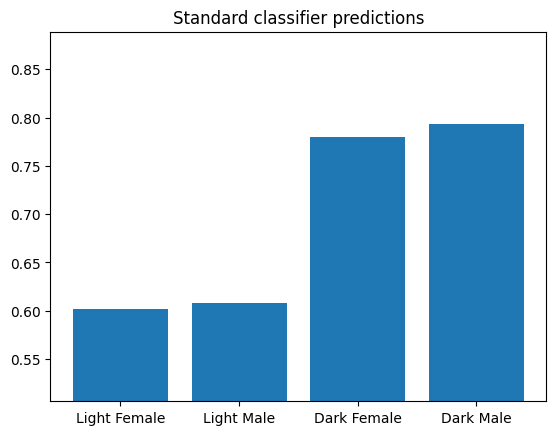

In [14]:
### Evaluate the standard CNN on the test data ###
standard_classifier_probs_list = [] # store each demographic's probabilities
with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x) # [B, 1]
        probs = torch.sigmoid(logits) # [B, 1]
        probs = torch.squeeze(probs, dim=-1) # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())
standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)
# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1) # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

#Variational autoencoder (VAE) for learning latent structure

Understanding VAEs: loss function

In [15]:
### Defining the VAE loss function ###
""" Function to calculate VAE loss given:
    an input x,
    reconstructed output x_recon,
    encoded means mu,
    encoded log of standard deviation logsigma,
    weight parameter for the latent loss kl_weight
"""
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
    # in the text block directly above
    latent_loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    # TODO: Define the reconstruction loss as the mean absolute pixel-wise
    # difference between the input and reconstruction. Hint: you'll need to
    # use torch.mean, and specify the dimensions to reduce over.
    # For example, reconstruction loss needs to average
    # over the height, width, and channel image dimensions.
    # https://pytorch.org/docs/stable/generated/torch.mean.html
    reconstruction_loss = torch.mean(torch.abs(x - x_recon), dim=(1, 2, 3))
    # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
    # in the text block directly above
    vae_loss = torch.mean(reconstruction_loss + kl_weight * latent_loss)
    return vae_loss

Understanding VAEs: reparameterization

In [16]:
### VAE Reparameterization ###
"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
    # Generate random noise with the same shape as z_mean, sampled from a standard normal distribution (mean=0, std=1)
    eps = torch.randn_like(z_mean)
    # # TODO: Define the reparameterization computation!
    # # Note the equation is given in the text block immediately above.
    z = z_mean + torch.exp(0.5 * z_logsigma) * eps
    return z

#Debiasing variational autoencoder (DB-VAE)

Defining the DB-VAE loss function

In [17]:
### Loss function for DB-VAE ###
"""Loss function for DB-VAE.
# Arguments
x: true input x
x_pred: reconstructed x
y: true label (face or not face)
y_logit: predicted labels
mu: mean of latent distribution (Q(z|X))
logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
total_loss: DB-VAE total loss
classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    # TODO: call the relevant function to obtain VAE loss
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO
    # TODO: define the classification loss using binary_cross_entropy
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y.unsqueeze(1)) # TODO
    # Use the training data labels to create variable face_indicator:
    # indicator that reflects which training data are images of faces
    y = y.float()
    face_indicator = (y == 1.0).float()
    # TODO: define the DB-VAE total loss! Use torch.mean to average over all
    # samples
    total_loss = torch.mean(classification_loss + vae_loss * face_indicator) # TODO
    return total_loss, classification_loss

DB-VAE architecture

In [18]:
### Define the decoder portion of the DB-VAE ###
n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables
def make_face_decoder_network(latent_dim=100, n_filters=12):
    """
    Function builds a face-decoder network.
    Args:
        latent_dim (int): the dimension of the latent representation
        n_filters (int): base number of convolutional filters
    Returns:
        decoder_model (nn.Module): the decoder network
    """
    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim, n_filters):
            super(FaceDecoder, self).__init__()
            self.latent_dim = latent_dim
            self.n_filters = n_filters
            # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters), nn.ReLU()
            )
            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
                nn.ConvTranspose2d(
                    in_channels=4 * n_filters,
                    out_channels=2 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
                nn.ConvTranspose2d(
                    in_channels=n_filters,
                    out_channels=3,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )
        def forward(self, z):
            """
            Forward pass of the decoder.
            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].
            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z) # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4) # [B, 6n_filters, 4, 4]
            # Upsample through transposed convolutions
            x = self.deconv(x) # [B, 3, 64, 64]
            return x
    return FaceDecoder(latent_dim, n_filters)

In [20]:
### Defining and creating the DB-VAE ###
class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim
        # Define the number of outputs for the encoder.
        self.encoder = make_standard_classifier(n_outputs=2 * latent_dim + 1)
        self.decoder = make_face_decoder_network()
    # function to feed images into encoder, encode the latent space, and output
    def encode(self, x):
        encoder_output = self.encoder(x)
        # classification prediction
        y_logit = encoder_output[:, 0].unsqueeze(-1)
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]
        return y_logit, z_mean, z_logsigma
    # VAE reparameterization: given a mean and logsigma, sample latent variables
    def reparameterize(self, z_mean, z_logsigma):
        # TODO: call the sampling function defined above
        z = sampling(z_mean, z_logsigma) # TODO
        return z
    # Decode the latent space and output reconstruction
    def decode(self, z):
        # TODO: use the decoder to output the reconstruction
        reconstruction = self.decoder(z) # TODO
        return reconstruction
    # The forward function will be used to pass inputs x through the core VAE
    def forward(self, x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)
        # TODO: reparameterization
        z = self.reparameterize(z_mean, z_logsigma) # TODO
        # TODO: reconstruction
        recon = self.decode(z) # TODO
        return y_logit, z_mean, z_logsigma, recon
    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

dbvae = DB_VAE(latent_dim)

Adaptive resampling for automated debiasing with DB-VAE

In [21]:
def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []
    # If images is NumPy, convert once outside the loop
    images_t = torch.from_numpy(images).float()
    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to(device).permute(0, 3, 1, 2)
            # Forward pass on this chunk only
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())
    # Concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0) # shape [N, latent_dim]
    mu = z_mean_full.numpy() # convert to NumPy if needed
    return mu

In [22]:
### Resampling algorithm for DB-VAE ###
"""Function that recomputes the sampling probabilities for images within a batch
based on how they distribute across the training data"""
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)
    # consider the distribution for each latent variable
    for i in range(latent_dim):
        latent_distribution = mu[:, i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )
        # find which latent bin every data sample falls in
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")
        # TODO: call the digitize function to find which bins in the latent distribution
        # every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO
        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        # invert the density function
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])
        # TODO: normalize all probabilities
        p = p / np.sum(p) # TODO
        # TODO: update sampling probabilities by considering whether the newly
        # computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(training_sample_p, p) # TODO
    # final normalization
    training_sample_p /= np.sum(training_sample_p)
    return training_sample_p

Starting epoch 2/2
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

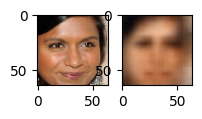

 14%|█▍        | 495/3434 [00:04<00:28, 102.45it/s]

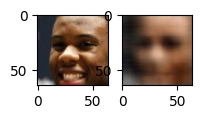

 29%|██▉       | 993/3434 [00:10<00:32, 74.25it/s]

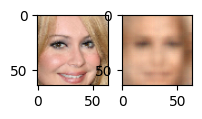

 43%|████▎     | 1492/3434 [00:15<00:18, 104.87it/s]

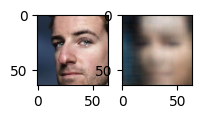

 58%|█████▊    | 1999/3434 [00:21<00:16, 85.70it/s]

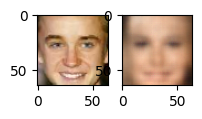

 73%|███████▎  | 2494/3434 [00:26<00:09, 98.53it/s]

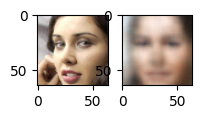

 87%|████████▋ | 2993/3434 [00:31<00:04, 98.81it/s]

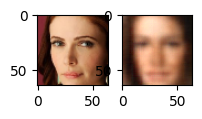

100%|██████████| 3434/3434 [00:37<00:00, 92.14it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : rainy_setback_1479
COMET INFO:     url                   : https://www.comet.com/sathikaranathunga/6s191-lab2-part2-dbvae/73ddcb4a691d45daa896ea9cb2062def
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (5183.4091796875, 145348.8125)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1z4_6b0i5O8u0u1ANmuLGaRebDzbSA6G0
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     latent_dim    : 100
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     en

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import IPython.display

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=2,  # DB-VAE needs slightly more epochs to train
)

# Assuming create_experiment, loader, device, and DB_VAE class are defined elsewhere
experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# Instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"]).to(device)
optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])

def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_pred, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

    # Classification loss
    # Ensure y is reshaped to [batch_size, 1] if it's [batch_size]
    if len(y.shape) == 1:
        y = y.unsqueeze(1)  # Reshape from [32] to [32, 1]
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y.float())

    # Combine losses (adjust weighting as needed)
    total_loss = recon_loss + kl_loss + classification_loss
    return total_loss, classification_loss

def debiasing_train_step(x, y):
    optimizer.zero_grad()
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    loss.backward()
    optimizer.step()
    return loss

# Get training faces from data loader
all_faces = loader.get_all_train_faces()

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute data sampling probabilities
    p_faces = get_training_sample_probabilities(all_faces, dbvae)

    # Get a batch of training data and compute the training step
    for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Load a batch of data
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # Ensure y is [batch_size, 1] or [batch_size]
        if len(y.shape) == 1:
            y = y.unsqueeze(1)  # Reshape to [32, 1] if needed
        elif len(y.shape) > 2:
            y = y.squeeze()  # Remove extra dimensions if any

        # Loss optimization
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        experiment.log_metric("loss", loss_value, step=step)

        # Plot the progress every 500 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae, backend="pt")
        step += 1

experiment.end()

#Evaluation of DB-VAE on Test Dataset

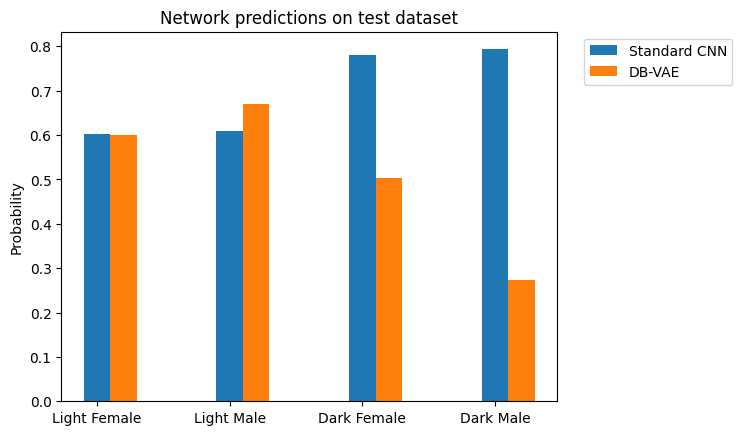

In [25]:
dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)
    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)
        dbvae_logits_list.append(logit.detach().cpu().numpy())
dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()
xx = np.arange(len(keys))
std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)
plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")
plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()